# Retrieve data

In [1]:
try:
    from google.colab import drive
    is_running_on_colab = True
except ImportError:
    is_running_on_colab = False

if is_running_on_colab:
    # Mount Google Drive
    drive.mount('/content/drive')


In [2]:
import time
start_notebook = time.time()

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
# Option to generate mock data
generate_mock_data = False # Set to True to generate mock data
max_mock_depth_ft = 2000 # Define maximum depth for mock data

In [5]:
well_name = "LLB-10"
if not generate_mock_data:
  if is_running_on_colab:
    # Load data from Google Drive, if running on Google Colab
    colab_repo_dir = "/content/drive/MyDrive/riset-fttm-gdrive/cuml-tf-model-hydrocarbon-prediction"
    data = pd.read_csv(f"{colab_repo_dir}/data/interpreted/interpreted_{well_name}.csv", sep=',')
  else:
    # Load data from local directory
    data = pd.read_csv(f"./data/interpreted/interpreted_{well_name}.csv", sep=',')

In [6]:
if generate_mock_data:
    print(f"Generating mock data up to {max_mock_depth_ft} ft for well {well_name}...")
    mock_depth_step = 0.5
    mock_dept_values = np.arange(0, max_mock_depth_ft, mock_depth_step)
    num_mock_rows = len(mock_dept_values)

    mock_data_dict = {'DEPT': mock_dept_values}

    feature_cols_for_mock = ['CALI','DRHO','GR','MR','NPHI_corr','PEF','RHOB_CORR','ROP']

    for col in feature_cols_for_mock:
        mock_data_dict[col] = np.random.rand(num_mock_rows) * 100

    mock_data_dict['hydrocarbon_formation_class'] = np.random.randint(0, 2, num_mock_rows)

    data = pd.DataFrame(mock_data_dict)

    print(f"Mock data generated for well {well_name} with {num_mock_rows} rows and columns: {list(data.columns)}.")
    print("Mock data head:")
    print(data.head())

In [7]:
df=data[['DRHO','GR','MR','NPHI_corr','PEF','RHOB_CORR']]
df

,DRHO,GR,MR,NPHI_corr,PEF,RHOB_CORR
0,0.051,88.200,0.875,0.4841,2.570,2.103
1,0.050,85.650,0.874,0.4744,2.582,2.130
2,0.064,79.358,0.900,0.4845,2.594,2.177
3,0.077,74.004,0.917,0.5475,2.613,2.184
4,0.081,78.938,0.973,0.6065,2.660,2.142
...,...,...,...,...,...,...
7103,0.206,48.022,1.943,0.3222,4.039,2.595
7104,0.158,51.742,1.981,0.3199,3.960,2.555
7105,0.089,54.041,2.015,0.3278,3.849,2.477
7106,0.052,52.710,1.962,0.3315,3.949,2.432


# Data Preparation

## Train/Test Splitting

In [8]:
# Misalkan 'data' adalah DataFrame Anda dan 'df' adalah fitur yang telah Anda ekstrak
X = df  # Fitur
y = data['hydrocarbon_formation_class']  # Label

# Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
X_train.describe()

,DRHO,GR,MR,NPHI_corr,PEF,RHOB_CORR
count,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000
mean,0.153765,60.130491,1.433918,0.410088,2.969691,2.346557
std,0.103196,11.080574,1.067113,0.052479,0.702442,0.109542
min,-0.196000,17.780000,0.561000,0.136700,-0.202000,1.620400
25%,0.091000,52.844750,1.090000,0.382900,2.718250,2.288000
50%,0.134000,62.143500,1.226000,0.408500,2.928000,2.353000
75%,0.187000,68.129500,1.433000,0.442000,3.149750,2.410000
max,0.930000,90.688000,24.142000,0.623900,16.001000,3.433000


## Data Imbalance Handling

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
# X_train and y_train are available from CELL INDEX 10
print("Original training data shape:", X_train.shape, y_train.shape)
print("Original training class distribution:\n", y_train.value_counts())

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nShape of training data after SMOTE:", X_train_smote.shape, y_train_smote.shape)
print("Class distribution after SMOTE:\n", y_train_smote.value_counts())

# Update X_train and y_train to be the oversampled versions
X_train = X_train_smote
y_train = y_train_smote

Original training data shape: (5686, 6) (5686,)
Original training class distribution:
 hydrocarbon_formation_class
0    5326
1     360
Name: count, dtype: int64

Shape of training data after SMOTE: (10652, 6) (10652,)
Class distribution after SMOTE:
 hydrocarbon_formation_class
0    5326
1    5326
Name: count, dtype: int64


## Apply Quantile Transformation

In [12]:
from sklearn.preprocessing import QuantileTransformer
def transform_quantile(X_train, X_test, X):
    qt_transformer = QuantileTransformer(output_distribution='normal')
    dfs = [X_train, X_test, X]
    qt_dfs = [None,None,None]
    for i, df in enumerate(dfs):
        if (i == 0): #only perform fit_transform on training data
            qt_dfs[i] = pd.DataFrame(qt_transformer.fit_transform(df))
        else:
            qt_dfs[i] = pd.DataFrame(qt_transformer.transform(df))
        qt_dfs[i].columns = df.columns.values
        qt_dfs[i].index = df.index.values
    return qt_dfs[0], qt_dfs[1], qt_dfs[2] #X_train, X_test, X

In [13]:
X_train, X_test, X = transform_quantile(X_train, X_test, X)

## Feature Scaling

karena menggunakan Quatile transformation dengan output gaussian, masing masing kolom secara otomatis ditransformasi ke distribusi normal baku, atau distribusi normal dengan rataan nol dan standar deviasi 1, oleh karena itu tidak diperlukan tambahan scaling.

In [14]:
X_train.describe()

,DRHO,GR,MR,NPHI_corr,PEF,RHOB_CORR
count,10652.000000,10652.000000,10652.000000,10652.000000,10652.000000,10652.000000
mean,0.000698,-0.000189,-0.000540,-0.001442,0.001765,0.002488
std,0.999067,0.998468,1.001910,1.003145,1.001198,0.999657
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.670700,-0.675235,-0.674717,-0.676892,-0.676339,-0.672245
50%,0.001105,0.001993,0.001833,-0.001570,0.002154,0.002006
75%,0.673702,0.672449,0.676133,0.673590,0.676854,0.673702
max,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338


# Training setup

In [15]:
import time
import numpy as np
from sklearn.model_selection import GridSearchCV


sk_train_accuracy={}
sk_test_accuracy={}

cu_train_accuracy={}
cu_test_accuracy={}

sk_crossValidation_accuracy={}
cu_crossValidation_accuracy={}

sk_models = {} #sklearn models
cu_models = {} #cuml models

sk_times = {}
cu_times = {}

sk_pred = {}
cu_pred = {}

sk_pred_times = {}
cu_pred_times = {}

In [16]:
# test CuML availability & is working
try:
    import cuml
    kmeans = cuml.KMeans(n_clusters=2)
    # Create minimal dummy data
    dummy_data = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8]])
    kmeans.fit(dummy_data)
    # Attempt to fit the model
    has_cuml = True
    print("cuML is found and working")
except ImportError:
    has_cuml = False
    print("cuML not found. Please ensure cuML is installed.")
except Exception as e:
    has_cuml = False
    print(f"cuML couldn't be initialized or used. Error: {e}")


cuML not found. Please ensure cuML is installed.


# Models

## SVM

In [17]:
model_name = "SVM"

In [18]:
from sklearn.svm import SVC as SklearnSVC
# Attempt to import cuML's SVC
try:
    from cuml.svm import SVC as cuMLSVC
except ImportError:
    print("cuML SVC not available. Please ensure cuML is installed and compatible with your environment.")

cuML SVC not available. Please ensure cuML is installed and compatible with your environment.


In [19]:
# Parameter grid for both models
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# 1) scikit-learn SVM with GridSearchCV
sk_models[model_name] = GridSearchCV(
    estimator=SklearnSVC(kernel='rbf'),
    param_grid=param_grid,
    cv=5,
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
sk_models[model_name].fit(X_train, y_train)
time_end = time.time()
sk_times[model_name] = time_end - time_start

# 2) cuML SVM with the same GridSearchCV
if has_cuml:
    cu_models[model_name] = GridSearchCV(
        estimator=cuMLSVC(kernel='rbf'),
        param_grid=param_grid,
        cv=5,
        verbose=3,
        # Note: cuML estimator runs on GPU; this grid search runs on CPU orchestrating GPU calls
        n_jobs=1  # avoid multiprocessing issues with GPU
    )

    time_start = time.time()
    cu_models[model_name].fit(X_train, y_train)
    time_end = time.time()
    cu_times[model_name] = time_end - time_start
    print(f"cuml GridSearchCV training time ({model_name}) : {cu_times[model_name]:.2f} seconds")
    print(f"cuml Best parameters ({model_name}): {cu_models[model_name].best_params_}")
else:
    print("cuML is not installed or GPU not available. Please install RAPIDS cuML to run this benchmark.")

print(f"scikit-learn GridSearchCV training time ({model_name}) : {sk_times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {sk_models[model_name].best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
cuML is not installed or GPU not available. Please install RAPIDS cuML to run this benchmark.
scikit-learn GridSearchCV training time (SVM) : 6.80 seconds
scikit-learn Best parameters (SVM): {'C': 10, 'gamma': 'auto'}


## K-Nearest Neighbors

In [20]:
model_name = "KNN"

In [21]:
from sklearn.neighbors import KNeighborsClassifier as SklearnKNeighborsClassifier
# Attempt to import cuML's KNeighborsClassifier
try:
    from cuml.neighbors import KNeighborsClassifier as cuMLKNeighborsClassifier
    # has_cuml is already defined from SVM section, assuming if SVM cuml is available, KNN cuml is too.
except ImportError:
    # If cuML was previously found but KNN specific part is missing, update has_cuml for KNN context if necessary
    # For simplicity, we rely on the initial has_cuml check. If specific components are missing,
    # the cuML KNN block will be skipped or error out, which is acceptable.
    # A more robust check could be:
    # try: from cuml.svm import SVC as cuMLSVC; has_cuml_svm = True except: has_cuml_svm = False
    # try: from cuml.neighbors import KNeighborsClassifier as cuMLKNeighborsClassifier; has_cuml_knn = True except: has_cuml_knn = False
    pass # Rely on global has_cuml

In [22]:
# Parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# 1) scikit-learn KNN with GridSearchCV
sk_models[model_name] = GridSearchCV(
    estimator=SklearnKNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=5,
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
sk_models[model_name].fit(X_train, y_train)
time_end = time.time()
sk_times[model_name] = time_end - time_start

# 2) cuML KNN with the same GridSearchCV (adapted for cuML)
if has_cuml:
    try:
        # Ensure cuMLKNeighborsClassifier was imported
        cuMLKNeighborsClassifier

        cu_models[model_name] = GridSearchCV(
            estimator=cuMLKNeighborsClassifier(), # cuML KNN
            param_grid=param_grid_knn, # Using the same grid, ensure params are compatible
            cv=5,
            verbose=3,
            n_jobs=1 # Potentially can be >1 if managed carefully, but 1 is safer for GPU resources with GridSearchCV
        )

        time_start = time.time()
        # cuML's KNN might prefer numpy arrays or cuDF dataframes
        # X_train and y_train are pandas, which cuml usually handles.
        # If issues arise, convert: X_train_cu = X_train.to_numpy(), y_train_cu = y_train.to_numpy()
        cu_models[model_name].fit(X_train, y_train)
        time_end = time.time()
        cu_times[model_name] = time_end - time_start
        print(f"cuml GridSearchCV training time ({model_name}) : {cu_times[model_name]:.2f} seconds")
        print(f"cuml Best parameters ({model_name}): {cu_models[model_name].best_params_}")
    except NameError: # handles if cuMLKNeighborsClassifier was not imported
        print(f"cuML KNeighborsClassifier not available. Skipping cuML {model_name} training.")
    except Exception as e:
        print(f"An error occurred during cuML {model_name} training: {e}")
        # Optionally, remove the model key if setup failed partway
        if model_name in cu_models: del cu_models[model_name]
        if model_name in cu_times: del cu_times[model_name]

else:
    print(f"cuML is not installed or GPU not available. Skipping cuML {model_name} benchmark.")

print(f"scikit-learn GridSearchCV training time ({model_name}) : {sk_times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {sk_models[model_name].best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
cuML is not installed or GPU not available. Skipping cuML KNN benchmark.
scikit-learn GridSearchCV training time (KNN) : 0.87 seconds
scikit-learn Best parameters (KNN): {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


## Random Forest

In [23]:
model_name = "RF"

In [24]:
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier
# Attempt to import cuML's RandomForestClassifier
try:
    from cuml.ensemble import RandomForestClassifier as cuMLRandomForestClassifier
    # has_cuml is already defined, assuming if previous cuML models are available, RF is too.
except ImportError:
    # Pass, relying on global has_cuml. Specific check for cuMLRandomForestClassifier will happen in the training block.
    pass

In [25]:
# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200], # Number of trees in the forest
    'max_depth': [None, 10, 20],    # Maximum depth of the tree
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],   # Minimum number of samples required to be at a leaf node
    # 'max_features': ['auto', 'sqrt'] # Number of features to consider when looking for the best split (cuML might have different defaults/options)
    # For cuML compatibility, specific parameters like 'max_features' might need adjustment or careful selection.
    # cuML RandomForestClassifier has slightly different parameter names or accepted values for some arguments.
    # e.g. max_features in cuML can be int, float, or 'auto' (auto is sqrt(n_features)).
}

# 1) scikit-learn RandomForest with GridSearchCV
sk_models[model_name] = GridSearchCV(
    estimator=SklearnRandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5, # Using 3-fold CV for RF due to potentially longer training times
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
sk_models[model_name].fit(X_train, y_train)
time_end = time.time()
sk_times[model_name] = time_end - time_start


# 2) cuML RandomForest with GridSearchCV (adapted for cuML)
if has_cuml:
    try:
        # Ensure cuMLRandomForestClassifier was imported
        cuMLRandomForestClassifier

        # cuML specific parameter adjustments if necessary.
        # For example, cuML's RandomForestClassifier might not support all string options for max_features like sklearn.
        # It typically supports int (number of features) or float (fraction of features). 'auto' is often sqrt(n_features).
        # Let's use a simplified grid or ensure compatibility.
        # The provided param_grid_rf should generally work if 'max_features' is omitted or set to a compatible value.

        cu_models[model_name] = GridSearchCV(
            estimator=cuMLRandomForestClassifier(random_state=42), # cuML RandomForest
            param_grid=param_grid_rf, # Ensure parameters are compatible with cuML RF
            cv=5, # Using 3-fold CV
            verbose=3,
            n_jobs=1 # Safer for GPU resources with GridSearchCV
        )

        time_start = time.time()
        cu_models[model_name].fit(X_train, y_train) # X_train, y_train are pandas, cuML handles this
        time_end = time.time()
        cu_times[model_name] = time_end - time_start
        print(f"cuml GridSearchCV training time ({model_name}) : {cu_times[model_name]:.2f} seconds")
        print(f"cuml Best parameters ({model_name}): {cu_models[model_name].best_params_}")
    except NameError:
        print(f"cuML RandomForestClassifier not available. Skipping cuML {model_name} training.")
    except Exception as e:
        print(f"An error occurred during cuML {model_name} training: {e}")
        if model_name in cu_models: del cu_models[model_name]
        if model_name in cu_times: del cu_times[model_name]
else:
    print(f"cuML is not installed or GPU not available. Skipping cuML {model_name} benchmark.")

print(f"scikit-learn GridSearchCV training time ({model_name}) : {sk_times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {sk_models[model_name].best_params_}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
cuML is not installed or GPU not available. Skipping cuML RF benchmark.
scikit-learn GridSearchCV training time (RF) : 29.30 seconds
scikit-learn Best parameters (RF): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


# LLB-10 trained model on LLB-10: Prediction & Model Evaluation

--- Evaluating: SVM ---

-- scikit-learn --
Prediction Duration: 0.45 seconds
Train Accuracy: 0.9501
Test Accuracy: 0.9149
Best Cross-Validation Score: 0.9415
Training Duration: 6.80 seconds
Confusion Matrix (Test Set):


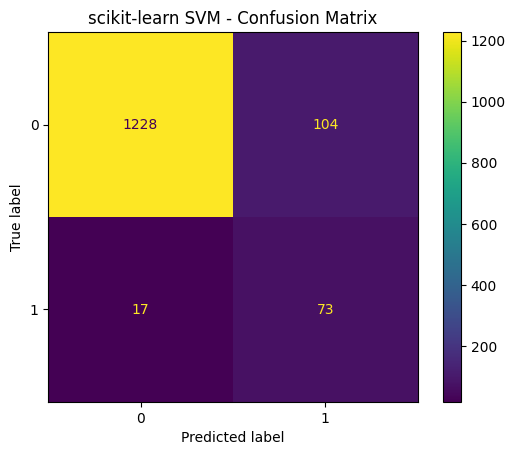


-- cuML --
cuML SVM was not run as cuML model for it is not available.


--- Evaluating: KNN ---

-- scikit-learn --
Prediction Duration: 0.07 seconds
Train Accuracy: 1.0000
Test Accuracy: 0.9198
Best Cross-Validation Score: 0.9472
Training Duration: 0.87 seconds
Confusion Matrix (Test Set):


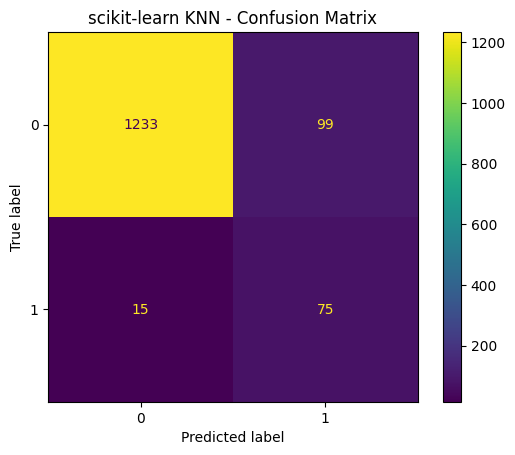


-- cuML --
cuML KNN was not run as cuML model for it is not available.


--- Evaluating: RF ---

-- scikit-learn --
Prediction Duration: 0.05 seconds
Train Accuracy: 1.0000
Test Accuracy: 0.9402
Best Cross-Validation Score: 0.9612
Training Duration: 29.30 seconds
Confusion Matrix (Test Set):


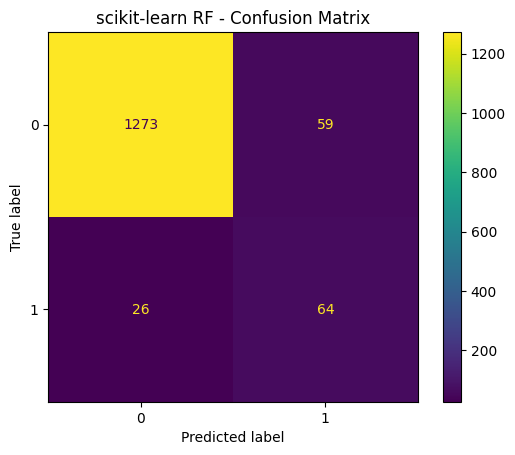


-- cuML --
cuML RF was not run as cuML model for it is not available.



Summary of Accuracies and Times:
scikit-learn Train Accuracies: {'SVM': 0.950056327450244, 'KNN': 1.0, 'RF': 1.0}
CuML Train Accuracies: {}
scikit-learn Test Accuracies: {'SVM': 0.9149085794655415, 'KNN': 0.919831223628692, 'RF': 0.940225035161744}
CuML Test Accuracies: {}
scikit-learn Cross-Validation Accuracies: {'SVM': np.float64(0.941514200170521), 'KNN': np.float64(0.9472407540818193), 'RF': np.float64(0.9612285003624124)}
CuML Cross-Validation Accuracies: {}
scikit-learn Training Times: {'SVM': 6.79712438583374, 'KNN': 0.8679280281066895, 'RF': 29.298292636871338}
cuML Training Times: {}
scikit-learn Prediction Times: {'SVM': 0.4493992328643799, 'KNN': 0.06739401817321777, 'RF': 0.0540471076965332}
cuML Prediction Times: {}


In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Comparison and Evaluation ---
model_names = list(sk_models.keys()) # Assuming cu_models will have the same keys if cuML is available

for model_name in model_names:
    print(f"--- Evaluating: {model_name} ---")

    # --- scikit-learn model ---
    if model_name in sk_models:
        print("\n-- scikit-learn --")
        best_sk_model = sk_models[model_name].best_estimator_

        # Predictions
        y_pred_train_sk = best_sk_model.predict(X_train)
        y_pred_test_sk = best_sk_model.predict(X_test)
        start_time = time.time()
        sk_pred[model_name] = best_sk_model.predict(X)
        end_time = time.time()
        sk_pred_times[model_name] = end_time - start_time
        print(f"Prediction Duration: {sk_pred_times[model_name]:.2f} seconds")

        # Accuracy
        train_accuracy_sk = accuracy_score(y_train, y_pred_train_sk)
        test_accuracy_sk = accuracy_score(y_test, y_pred_test_sk)
        sk_train_accuracy[model_name] = train_accuracy_sk
        sk_test_accuracy[model_name] = test_accuracy_sk
        print(f"Train Accuracy: {train_accuracy_sk:.4f}")
        print(f"Test Accuracy: {test_accuracy_sk:.4f}")

        # Cross-validation score
        cv_score_sk = sk_models[model_name].best_score_
        sk_crossValidation_accuracy[model_name] = cv_score_sk
        print(f"Best Cross-Validation Score: {cv_score_sk:.4f}")

        # Duration
        print(f"Training Duration: {sk_times[model_name]:.2f} seconds")

        # Confusion Matrix
        print("Confusion Matrix (Test Set):")
        cm_sk = confusion_matrix(y_test, y_pred_test_sk)
        disp_sk = ConfusionMatrixDisplay(confusion_matrix=cm_sk, display_labels=best_sk_model.classes_)
        disp_sk.plot()
        plt.title(f"scikit-learn {model_name} - Confusion Matrix")
        plt.show()


    # --- cuML model ---
    print("\n-- cuML --")
    if has_cuml and model_name in cu_models:
        best_cu_model = cu_models[model_name].best_estimator_

        # Predictions

        # Note: cuML predict might require cuDF DataFrame or NumPy array
        # Ensuring X_train and X_test are in a compatible format (e.g., NumPy)
        # If they are pandas DataFrames, cuML usually handles them, but explicit conversion can be safer.
        y_pred_train_cu = best_cu_model.predict(X_train.to_numpy() if hasattr(X_train, 'to_numpy') else X_train)
        y_pred_test_cu = best_cu_model.predict(X_test.to_numpy() if hasattr(X_test, 'to_numpy') else X_test)
        start_time = time.time()
        cu_pred[model_name] = best_cu_model.predict(X.to_numpy() if hasattr(X, 'to_numpy') else X)
        end_time = time.time()
        cu_pred_times[model_name] = end_time - start_time
        print(f"Prediction Duration: {cu_pred_times[model_name]:.2f} seconds")

        # If predictions are cuPy arrays, convert them to NumPy for scikit-learn metrics
        if hasattr(y_pred_train_cu, 'get'): # Check if it's a cuPy array
            y_pred_train_cu = y_pred_train_cu.get()
        if hasattr(y_pred_test_cu, 'get'): # Check if it's a cuPy array
            y_pred_test_cu = y_pred_test_cu.get()


        # Accuracy
        train_accuracy_cu = accuracy_score(y_train, y_pred_train_cu) # y_train is pandas Series, compatible
        test_accuracy_cu = accuracy_score(y_test, y_pred_test_cu)   # y_test is pandas Series, compatible
        cu_train_accuracy[model_name] = train_accuracy_cu
        cu_test_accuracy[model_name] = test_accuracy_cu
        print(f"Train Accuracy: {train_accuracy_cu:.4f}")
        print(f"Test Accuracy: {test_accuracy_cu:.4f}")

        # Cross-validation score
        cv_score_cu = cu_models[model_name].best_score_
        cu_crossValidation_accuracy[f"cu_{model_name}"] = cv_score_cu
        print(f"Best Cross-Validation Score: {cv_score_cu:.4f}")

        # Duration
        # if model_name in cu_times: # Check if cu_times was populated
        print(f"Training Duration: {cu_times[model_name]:.2f} seconds")

        # Confusion Matrix
        print("Confusion Matrix (Test Set):")
        cm_cu = confusion_matrix(y_test, y_pred_test_cu)
        # Ensure classes are correctly obtained for cuML model if different from sklearn
        # For SVC, .classes_ should be available after fitting.
        disp_cu = ConfusionMatrixDisplay(confusion_matrix=cm_cu, display_labels=best_cu_model.classes_)
        disp_cu.plot()
        plt.title(f"cuML {model_name} - Confusion Matrix")
        plt.show()
    else:
        print(f"cuML {model_name} was not run as cuML model for it is not available.")

    print("\n" + "="*40 + "\n")

print("\nSummary of Accuracies and Times:")
print("scikit-learn Train Accuracies:", sk_train_accuracy)
print("CuML Train Accuracies:", cu_train_accuracy)
print("scikit-learn Test Accuracies:", sk_test_accuracy)
print("CuML Test Accuracies:", cu_test_accuracy)
print("scikit-learn Cross-Validation Accuracies:", sk_crossValidation_accuracy)
print("CuML Cross-Validation Accuracies:", cu_crossValidation_accuracy)
print("scikit-learn Training Times:", sk_times)
print("cuML Training Times:", cu_times)
print("scikit-learn Prediction Times:", sk_pred_times)
print("cuML Prediction Times:", cu_pred_times)

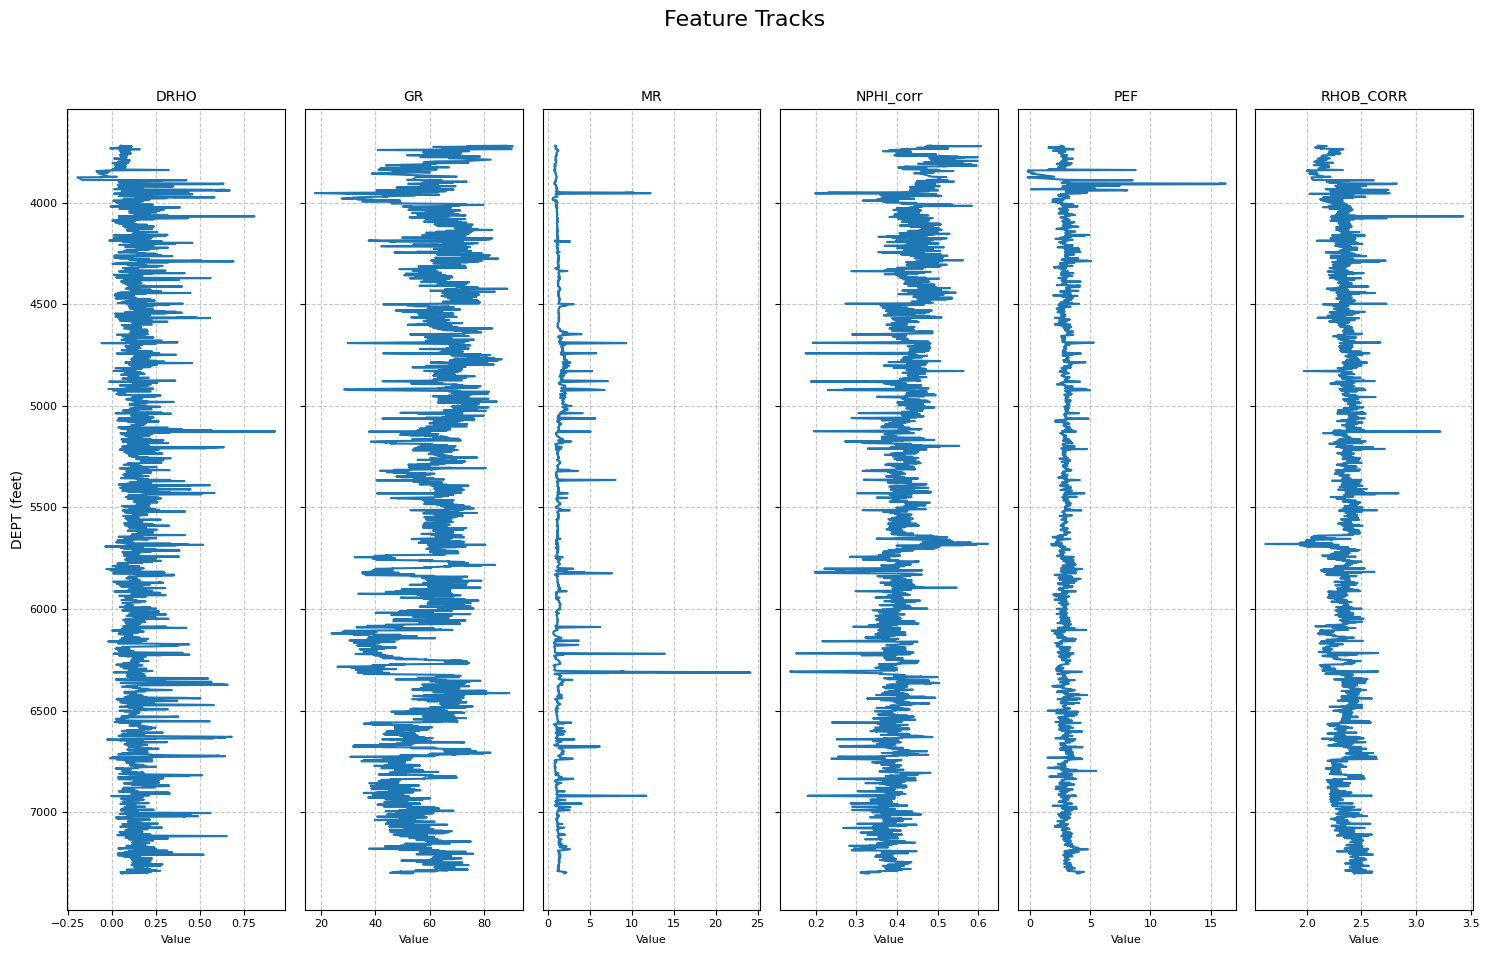

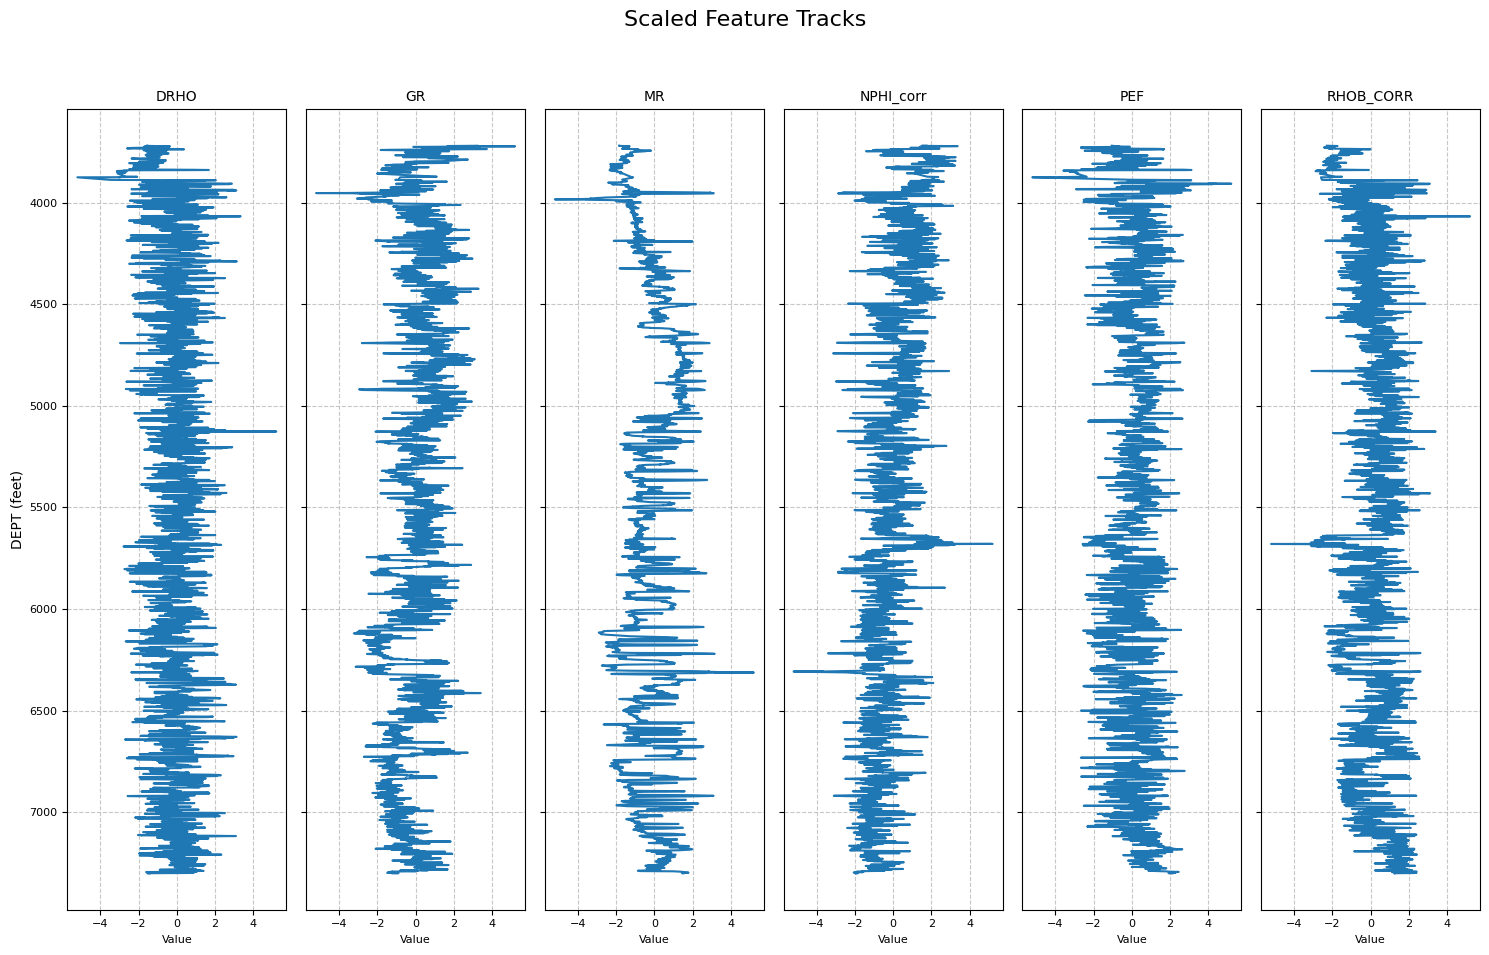

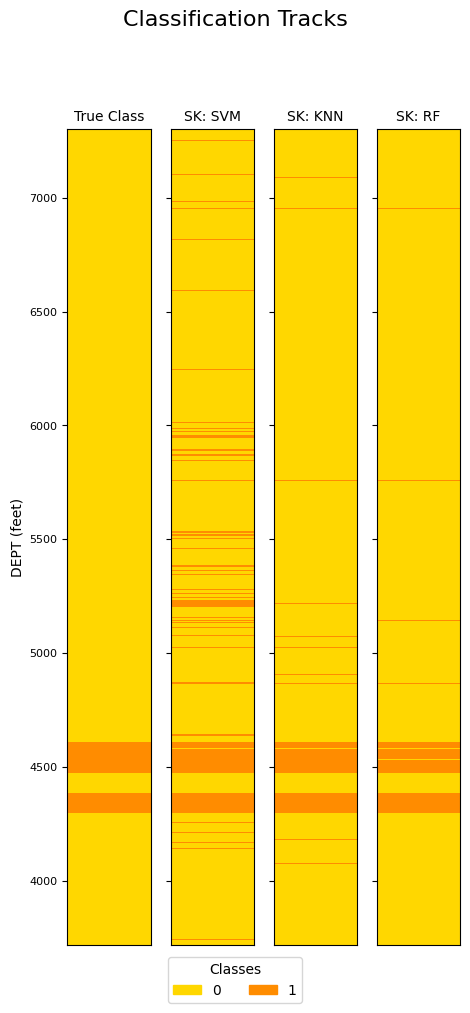

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# Ensure all necessary variables are defined from previous cells:
# data, df, y, sk_pred, cu_pred, has_cuml (for cuML models)
# X (to get the index for aligning predictions if they are numpy arrays)

if 'DEPT' not in data.columns:
    print("Error: 'DEPT' column not found in data DataFrame. Cannot generate depth plots.")
else:
    depth_column = data['DEPT']
    feature_names = df.columns.tolist()

    # Prepare labels and predictions (same as before)
    true_labels = y
    all_predictions_to_plot = {}
    all_predictions_to_plot['True Labels'] = true_labels
    for model_name, preds in sk_pred.items():
        all_predictions_to_plot[f'SK: {model_name}'] = preds
    if has_cuml and cu_pred:
        for model_name, preds_cu in cu_pred.items():
            if hasattr(preds_cu, 'get'):
                preds_np = preds_cu.get()
            else:
                preds_np = preds_cu
            all_predictions_to_plot[f'CU: {model_name}'] = preds_np

    # Define colors for classes (same as before)
    if isinstance(true_labels, np.ndarray):
        unique_classes = np.sort(np.unique(true_labels))
    else:
        unique_classes = np.sort(true_labels.unique())

    if len(unique_classes) == 1:
        plot_colors = ['gold']
    elif len(unique_classes) == 2:
        plot_colors = ['gold', 'darkorange']
    else:
        cmap_tab10 = plt.cm.get_cmap('tab10', len(unique_classes))
        plot_colors = [mcolors.to_hex(cmap_tab10(i)) for i in range(len(unique_classes))]

    class_to_int = {cls: i for i, cls in enumerate(unique_classes)}
    cmap_listed = mcolors.ListedColormap(plot_colors[:len(unique_classes)])


    # --- Figure 1: feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1: # Handle single feature case for axes indexing
            axes_features = [axes_features]
        fig_features.suptitle("Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(data[feature_name].loc[X.index], depth_column.loc[X.index])
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("No features to plot for feature tracks.")

    # --- Figure 2: scaled feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1: # Handle single feature case for axes indexing
            axes_features = [axes_features]
        fig_features.suptitle("Scaled Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(X[feature_name].loc[X.index], depth_column.loc[X.index])
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("No features to plot for scaled feature tracks.")

    # --- Figure 3: Classification Tracks ---
    num_classification_plots = len(all_predictions_to_plot)
    if num_classification_plots > 0:
        # Adjust figsize: width per plot can be smaller for classification tracks
        fig_class, axes_class = plt.subplots(1, num_classification_plots, figsize=(num_classification_plots * 1.2, 10), sharey=True)
        if num_classification_plots == 1: # Handle single classification plot case
            axes_class = [axes_class]
        fig_class.suptitle("Classification Tracks", fontsize=16, y=0.98)

        plot_order = ['True Labels'] + [k for k in all_predictions_to_plot.keys() if k != 'True Labels']

        for i, title in enumerate(plot_order):
            predictions_data = all_predictions_to_plot[title]
            ax = axes_class[i]

            if isinstance(predictions_data, pd.Series):
                if not predictions_data.index.equals(X.index):
                    # This should ideally not happen with consistent data handling
                    # For safety, one might reindex or ensure alignment upstream
                    print(f"Warning: Index mismatch for {title}. Plotting may be incorrect.")
                mapped_preds = predictions_data.map(class_to_int).fillna(-1)
            elif isinstance(predictions_data, np.ndarray):
                temp_series = pd.Series(predictions_data, index=X.index)
                mapped_preds = temp_series.map(class_to_int).fillna(-1)
            else:
                print(f"Warning: Data for {title} is of unexpected type: {type(predictions_data)}")
                continue

            labels_int = mapped_preds.values.reshape(-1, 1)
            vmin = 0
            vmax = len(plot_colors) - 1

            ax.imshow(labels_int, aspect='auto', cmap=cmap_listed,
                      extent=[0, 1, depth_column.loc[X.index].max(), depth_column.loc[X.index].min()],
                      interpolation='none', vmin=vmin, vmax=vmax)

            if title == 'True Labels':
                ax.set_title("True Class", fontsize=10)
            else:
                ax.set_title(title, fontsize=10)

            ax.set_xticks([])
            ax.set_xlabel("")
            ax.tick_params(axis='y', labelsize=8)
            if i == 0: # Set Y-axis label only for the first plot in this figure
                ax.set_ylabel("DEPT (feet)", fontsize=10)


        axes_class[0].invert_yaxis()

        if unique_classes is not None and len(unique_classes) > 0:
            patches = [plt.Rectangle((0,0),1,1, color=plot_colors[class_to_int[cls]]) for cls in unique_classes]
            legend_labels = [str(cls) for cls in unique_classes]
            fig_class.legend(patches, legend_labels, loc='lower center', ncol=len(unique_classes), bbox_to_anchor=(0.5, -0.02), title="Classes")

        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
    else:
        print("No classification data to plot.")


# Load LLD-14 LAS & do Quantile Transformation

# Predict using existing model trained on LLB-10

# LLB-10 trained model on LLB-14: Prediction & Model Evaluation

# Shutdown colab runtime

In [28]:
# Execution time
end_notebook = time.time()
print(f"Total notebook execution time: {end_notebook - start_notebook:.2f} seconds")

Total notebook execution time: 42.84 seconds


In [29]:
if is_running_on_colab:
    from google.colab import runtime
    runtime.unassign()